In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os
import math

class wifimodel():
    def __init__(self, location):
        self.train_dir = f'../../data/{location}/train_n/'
        self.test_dir = f'../../data/{location}/test_h/'
        
        self.location = location
        self.model_df = pd.DataFrame()
        self.test_df = pd.DataFrame()

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0

        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])

        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../../mag/{location}/magx.txt', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]

    def cal_area(self, posx, posy):
        cnt = 0
        temp = self.ref_mag_df.iloc[int(min(posx)): int(max(posx)), int(min(posy)): int(max(posy))]
        return sum(temp[temp != 0.0].count())
    
    def cal_area2(self, posx, posy):
        cnt = 0
        for i in range(len(posx)):
            if self.mag_df.iloc[posx[i], posy[i]] != 0.0:
                cnt += 1
        return cnt
    
    def define_range(self, range_num, rssi_range_num):
        self.range_num = range_num
        self.rssi_range_num = rssi_range_num
        
    def create_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        self.rssiwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        self.rssi_max = np.max(fil_model_df['RSSI'])
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = 1
                self.rssiwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = rssi

        
    def show_area_dist(self):
        plt.hist(pd.DataFrame(self.area_list).values)
        plt.show()
    
    
    def test_one(self, idx):
        tot_cnt = 0
        cnt = 0
        coords_list = []
        
        test_list = list(self.fil_test_df['x_y'].unique())[idx].split('\t')
        
        x = float(test_list[0])
        y = float(test_list[1])
        
        compare_list = np.array([0 for i in range(len(self.SSID_list))])
        compare_list_rssi = np.array([0 for i in range(len(self.SSID_list))])
        
        compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
        
        
        if compare_df.empty == False:
            for i in range(compare_df.shape[0]):
                if (compare_df.iloc[i, 4] in self.SSID_list):
                    compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1
                    compare_list_rssi[self.SSID_list.index(compare_df.iloc[i, 4])] = compare_df.iloc[i, 5]
                    
            temp_wifi = self.refwifi - compare_list
            temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
            
            temp_rssi_wifi = abs(self.rssiwifi - compare_list_rssi)
            temp_rssi_wifi = np.where(abs(temp_rssi_wifi) >= abs(self.rssi_max), 0, temp_rssi_wifi)
            
            sum_temp = temp_wifi.sum(axis=2)
            
            sum_temp_for_rssi = copy.deepcopy(sum_temp)
            
            sum_temp_for_rssi = np.where(sum_temp_for_rssi == 0, 0.00001, sum_temp_for_rssi)
            
            sum_rssi_temp = temp_rssi_wifi.sum(axis=2)
            
            sum_rssi_temp = sum_rssi_temp / sum_temp_for_rssi
            
            sum_np = np.unique(sum_temp.flatten())[:: -1]
            
            if len(sum_np) <= self.range_num:
                range_idx = len(sum_np) - 1
            else:
                range_idx = self.range_num

            if range_idx == -1:
                rangeval = 0
            else:
                rangeval = np.unique(sum_np)[:: - 1][range_idx]
            
            sum_rssi_np = np.unique(sum_rssi_temp[np.where(sum_temp >= rangeval)].flatten())
            
            if len(sum_rssi_np) <= self.rssi_range_num:
                range_idx = len(sum_rssi_np) - 1
            else:
                range_idx = self.rssi_range_num
            
            if range_idx == -1:
                rssi_rangeval = 0
            else:
                rssi_rangeval = np.unique(sum_rssi_np)[range_idx]
                        
            coords = np.where((sum_temp >= rangeval) & (sum_rssi_temp <= rssi_rangeval))
                                                                          
            coords_list.append([x, y, coords])
            
        
        return x, y, coords, compare_list_rssi

In [55]:
def intersect(list1_x, list1_y, list2_x, list2_y):    
    tot_ans_x = []
    tot_ans_y = []
    if len(list1_x) * len(list2_x) != 0.0:
        fin_min_x = int(max(min(list1_x), min(list2_x)))
        fin_max_x = int(min(max(list1_x), max(list2_x)))
        fin_min_y = int(max(min(list1_y), min(list2_y)))
        fin_max_y = int(min(max(list1_y), max(list2_y)))

        for x in range(fin_min_x, fin_max_x + 1):
            for y in range(fin_min_y, fin_max_y + 1):
                if x >= 0 and y >= 0 and model.mag_df.iloc[int(x), int(y)] != 0.0:
                    tot_ans_x.append(x)
                    tot_ans_y.append(y)
    
    return tot_ans_x, tot_ans_y

def make_range2(x_list, y_list):
    min_x = int(min(x_list))
    max_x = int(max(x_list))

    min_y = int(min(y_list))
    max_y = int(max(y_list))

    tot_ans_x = []
    tot_ans_y = []

    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            if 0 <= x < model.mag_df.shape[0] and 0 <= y < model.mag_df.shape[1]:
                    if model.mag_df.iloc[int(x), int(y)] != 0.0:
                        tot_ans_x.append(x)
                        tot_ans_y.append(y)

    return tot_ans_x, tot_ans_y

def add(x_list, y_list, x, y):
    
    for i in range(len(x_list)):
        if x_list[i] + x < 0:
            x_list[i] = 0
        elif x_list[i] + x > model.mag_df.shape[0]:
            x_list[i] = model.mag_df.shape[0] - 1
        else:
            x_list[i] = x_list[i] + x
    
    for i in range(len(y_list)):
        if y_list[i] + y < 0:
            y_list[i] = 0
        elif y_list[i] + y > model.mag_df.shape[1]:
            y_list[i] = model.mag_df.shape[1] - 1
        else:
            y_list[i] = y_list[i] + y
    return x_list, y_list

def add_by_gyro(x_list, y_list, my_angle, gyro, step_length):
    x_change = - (step_length * 10 * sin(((my_angle - gyro + 360) % 360) * pi / 180)) 
    y_change = step_length * 10 * cos(((my_angle - gyro + 360) % 360) * pi / 180)
    
    for i in range(len(x_list)):
        if x_list[i] + x_change < 0:
            x_list[i] = 0
        elif x_list[i] + x_change > model.mag_df.shape[0]:
            x_list[i] = model.mag_df.shape[0] - 1
        else:
            x_list[i] = int(x_list[i] + x_change)
    for i in range(len(y_list)):
        if y_list[i] + y_change < 0:
            y_list[i] = 0
        elif y_list[i] + y_change > model.mag_df.shape[1]:
            y_list[i] = model.mag_df.shape[1] - 1
        else:
            y_list[i] = int(y_list[i] + y_change)
    return x_list, y_list

import math
def cal_gyro(c1, c2, c3, c4):
    v1 = [c2[0] - c1[0], c2[1] - c1[1]]
    v2 = [c4[0] - c3[0], c4[1] - c3[1]]
    ang1 = math.atan2(v1[1], v1[0])
    ang2 = math.atan2(v2[1], v2[0])
    
    
    result = (math.degrees(ang1 - ang2) + 360) % 360

    
    return result

In [56]:
import time
from math import *
import os

# from codes.sequential.instant.InstantParticle_Mother import  InstantParticle_Mother
# from codes.sequential.instant.Map import Map
from InstantParticle_Mother import InstantParticle_Mother
from Map import Map

class InstantLocalization():
    def __init__(self, location_name, area_num = 1):
        # 맵파일 읽기
        self.instant_result = {"status_code":-1.0, "gyro_from_map":-1.0, "pos_x":-1.0, "pos_y":-1.0}
        self.mapVector_temp = []
        f = open(f"./instant/자기장맵/{location_name}/handhashmap_for_instant_3.txt", "r")
        while True:
            row = f.readline()
            if not row:
                break
            self.mapVector_temp.append(list(map(float, row.split("\t"))))
        self.mapVector = Map(f"./instant/자기장맵/{location_name}/handhashmap.txt")

        # 필요 변수들
        self.angleList = [i for i in range(0, 360, 10)]
        self.sampled_sequence_average_list = []
        self.cur_step = -1
        self.sampled_vector_magnitude = 0
        self.instant_particle_mother_list = []
        self.pre_state = 0 # 0 : ON HAND, 1 : IN POCKET, 2 : SWING
        self.cur_state = 0

        # ######### 포스코센터 ##########
        # self.vector_threshold = 5.0
        # self.vector_threshold_second = 3.0
        # self.magnitude_threshold = 3.0
        # self.firstThreshold = 7
        # self.weight_according_step = 0.5
        # self.vector_weight = 0.5
        # self.take_n_mother = 36
        # self.early_stop_in_n_mother = 10
        # ################################

        ## 하나스퀘어_wifi 최적화 parameter ##
        self.early_stop_in_n_mother = 10
        self.take_n_mother = 36
        self.vector_weight = 0.5
        self.weight_according_step = 0.12
        self.magnitude_threshold = 4.0
        self.vector_threshold_second = 7.0
        self.vector_threshold = 12.0
        self.firstThreshold = 12.0

        self.init_range = [[0, 0, 0, 0] for i in range(36)]
        self.refx = 0.0
        self.refy = 0.0
        self.area_num = area_num
        self.best_mother = []


    def define_range(self, _range):
        self.init_range = _range


    def check_in_range(self, x, y, i):
        x = float(x)
        y = float(y)

        result = False
        if (self.init_range[i][0] <= x) and (x <= self.init_range[i][1]) and (self.init_range[i][2] <= y) and(y <= self.init_range[i][3]):
            result = True
        return result


    def reset_all(self):
        # 필요 변수들
        self.angleList = [i for i in range(0, 360, 10)]
        self.sampled_sequence_average_list = []
        self.cur_step = -1
        self.sampled_vector_magnitude = 0.0
        self.instant_particle_mother_list = []
        self.instant_result = {"status_code":-1.0, "gyro_from_map":-1.0, "pos_x":-1.0, "pos_y":-1.0}

    def init_for_always_on_mode(self, cur_gyro):
        cur_gyro = int(float(cur_gyro))
        self.angleList = [i for i in range((360-cur_gyro)-90, (360-cur_gyro)+91, 10)]
        self.sampled_sequence_average_list = []
        self.cur_step = -1
        self.sampled_vector_magnitude = 0.0
        self.instant_particle_mother_list = []
        self.instant_result = {"status_code":-1.0, "gyro_from_map":-1.0, "pos_x":-1.0, "pos_y":-1.0}


    def __first_matching_with_map_and_create_mothers(self):
        for i in range(len(self.angleList)):
            self.instant_particle_mother_list.append(InstantParticle_Mother(self.angleList[i]))
            for row in self.mapVector_temp:
                if self.check_in_range(row[0], row[1], i):
                    self.instant_particle_mother_list[-1].appendChildren(row[:2], row[2:])



    def getLocation(self, stepLength, gyro):
        if self.instant_result["status_code"] == 200.0:
            self.init_for_always_on_mode(float(self.instant_result["gyro_from_map"]) + float(gyro))
        elif self.instant_result["status_code"] == 400.0:
            self.reset_all()

        self.cur_step += 1

        if self.cur_step == 0:
            for mother in self.instant_particle_mother_list:
                self.moveChildren(mother, stepLength, gyro)
            self.__first_matching_with_map_and_create_mothers()
            self.instant_result["status_code"] = 100.0

            idx = 0
 
            return self.instant_result

        cur_idx = -1
        while 1:
            cur_idx += 1
            if len(self.instant_particle_mother_list) == 0:
                self.instant_result["status_code"] = 400.0
                return self.instant_result
            particle_mother = self.instant_particle_mother_list[cur_idx]
            self.moveChildren(particle_mother, stepLength, gyro) # 아이들 움직이기. 움직이자마자 벽에 부딪히는 아이들은 다 죽이기.
            self.checkChildren(particle_mother)
            
            if len(particle_mother.particle_children_list) == 0: # 아이 안 갖고 있는 mother는 삭제.
                self.instant_particle_mother_list.remove(particle_mother)
                cur_idx -= 1

            if cur_idx == len(self.instant_particle_mother_list)-1:
                break

        self.instant_result = self.estimateInitialDirAndPos(self.instant_particle_mother_list, gyro)
        idx = 0

        return self.instant_result


    # 샘플링 된 자기장 벡터를 여러 방향으로 생성. 이 때, sequence의 평균값을 바로 제거 (bias normalization)
    # 여기 들어가는 벡터는 시작 방향을 기준으로 벡터 캘리브레이션 된 값.


    def cal_difference_angle(self, a, b):
        result1 = (abs(a - b) + 360) % 360
        result2 = 360 - result1
        if result1 <= result2:
            return result1
        else:
            return result2

    def estimateInitialDirAndPos(self, mother_list, gyro):
        num_of_mother = len(mother_list)

        if num_of_mother >= 3:
            if num_of_mother <= self.early_stop_in_n_mother: # 엄마가 3개이상 n개이하일 때, early stop 동작
                # TODO : 상위 5개 mother끼리 다시 instant 돌리기. 성공률 높이기 위함!
                # Do Something!
                sorted_mother = sorted(self.instant_particle_mother_list, key=lambda x: (len(x.particle_children_list), x.getAvgWeight()), reverse=True)
                first_mother = sorted_mother[0]
                second_mother = sorted_mother[1]

                if len(second_mother.particle_children_list) >= 1:
                    # first_mother와 second_mother가 친한 엄마라면, 강남 엄마 알고리즘 동작
                    if self.cal_difference_angle(first_mother.my_angle, second_mother.my_angle) <= 10:
                        first_mother_answer = self.calculate_answer_position(first_mother)
                        second_mother_answer = self.calculate_answer_position(second_mother)
                        if (first_mother_answer == (-1, -1) or second_mother_answer == (-1, -1)):
                            return {"status_code":100.0, "gyro_from_map":-1.0, "pos_x":-1.0, "pos_y":-1.0}

                        else:
                            distance_with_two_answer = sqrt((first_mother_answer[0]-second_mother_answer[0])**2 + (first_mother_answer[1]-second_mother_answer[1])**2) * 0.1
                            if distance_with_two_answer <= 1.5:
                                answer_dir_temp = (first_mother.my_angle + second_mother.my_angle) / 2 if (abs(first_mother.my_angle - second_mother.my_angle) != 350) else (first_mother.my_angle + second_mother.my_angle + 360) / 2
                                answer_dir = (((360 - answer_dir_temp)+ gyro)+360)%360
                                answer_x = (first_mother_answer[0] + second_mother_answer[0]) / 2
                                answer_y = (first_mother_answer[1] + second_mother_answer[1]) / 2
                                return {"status_code":200.0, "gyro_from_map":answer_dir, "pos_x":answer_x, "pos_y":answer_y}
                            else:
                                return {"status_code": 100.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}
                    # 엄마 하나 빼고, 나머지 엄마들의 자식이 하나밖에 남지 않았다면 early stop 동작
                    elif (len(second_mother.particle_children_list) == 1) and (len(first_mother.particle_children_list) != 1):
                        self.best_mother = first_mother
                    else:
                        return {"status_code": 100.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}

                else:
                    return {"status_code": 100.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}
            else:
                return {"status_code": 100.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}

        elif num_of_mother == 2:
            weight_sum_list = []
            for mother in mother_list:
                weight_sum = 0.0
                for children in mother.particle_children_list:
                    weight_sum += children.weight
                weight_sum_list.append(weight_sum)
            if weight_sum_list[0] >= weight_sum_list[1]:
                self.best_mother = mother_list[0]
            else:
                self.best_mother = mother_list[1]

        elif num_of_mother == 1:
            self.best_mother = mother_list[0]
        elif num_of_mother == 0:
            return {"status_code": 400.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}

        # 혹시 모를 에러를 방지
        num_of_children = len(self.best_mother.particle_children_list)
        if num_of_children == 0:
            return {"status_code": 400.0, "gyro_from_map": -1.0, "pos_x": -1.0, "pos_y": -1.0}
        # 정답 좌표 계산
        answer_x, answer_y = self.calculate_answer_position(self.best_mother)
        answer_dir = str((((360 - int(self.best_mother.my_angle)) + gyro) + 360) % 360)
        if (answer_x, answer_y) == (-1, -1): # 방향만 수렴
            return {"status_code": 101.0, "gyro_from_map": answer_dir, "pos_x": -1.0, "pos_y": -1.0}
        else:
            return {"status_code": 200.0, "gyro_from_map": answer_dir, "pos_x": answer_x, "pos_y": answer_y}

    def calculate_answer_position(self, mother) -> tuple:
        answer_x = 0.0
        answer_y = 0.0
        for children in mother.particle_children_list:
            answer_x += children.x
            answer_y += children.y
        num_of_children = len(mother.particle_children_list)
        answer_x = answer_x / num_of_children
        answer_y = answer_y / num_of_children
        dist_avg = 0
        for children in mother.particle_children_list:
            dist_avg += sqrt(((answer_x - children.x) ** 2 + (answer_y - children.y) ** 2)) * 0.1
        dist_avg = dist_avg / len(mother.particle_children_list)
        if dist_avg > 1.5:
            return (-1, -1)
        return (answer_x, answer_y)

    def moveChildren(self, particle_mother, step_length, gyro):
        cur_idx = -1
        while 1:
            gyro_result = gyro
            cur_idx += 1
            if cur_idx == len(particle_mother.particle_children_list):
                break
            children = particle_mother.particle_children_list[cur_idx]
            children.x -= step_length * 10 * sin((particle_mother.my_angle - gyro_result) * pi / 180)
            children.y += step_length * 10 * cos((particle_mother.my_angle - gyro_result) * pi / 180)

            # 벽에 부딪혔는지 검사. 부딪혔으면 바로 죽이기.
            if not self.mapVector.isPossiblePosition(children.x, children.y):
                particle_mother.removeChildren(cur_idx)
                cur_idx -= 1

    def checkChildren(self, particle_mother):
        cur_idx = -1
        while 1:
            cur_idx += 1
            if cur_idx == len(particle_mother.particle_children_list):
                break
            children = particle_mother.particle_children_list[cur_idx]
            # 벽에 부딪혔는지 검사. 부딪혔으면 바로 죽이기.
            if not self.check_in_range(children.x, children.y, int(particle_mother.my_angle / 10)):
                particle_mother.removeChildren(cur_idx)
                cur_idx -= 1

In [57]:
model = wifimodel('하나스퀘어_220523')

In [58]:
model.create_refwifi(-69)
model.define_range(6, 40)

/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_69950/3709125951.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')


In [59]:
import matplotlib.pyplot as plt
from celluloid import Camera

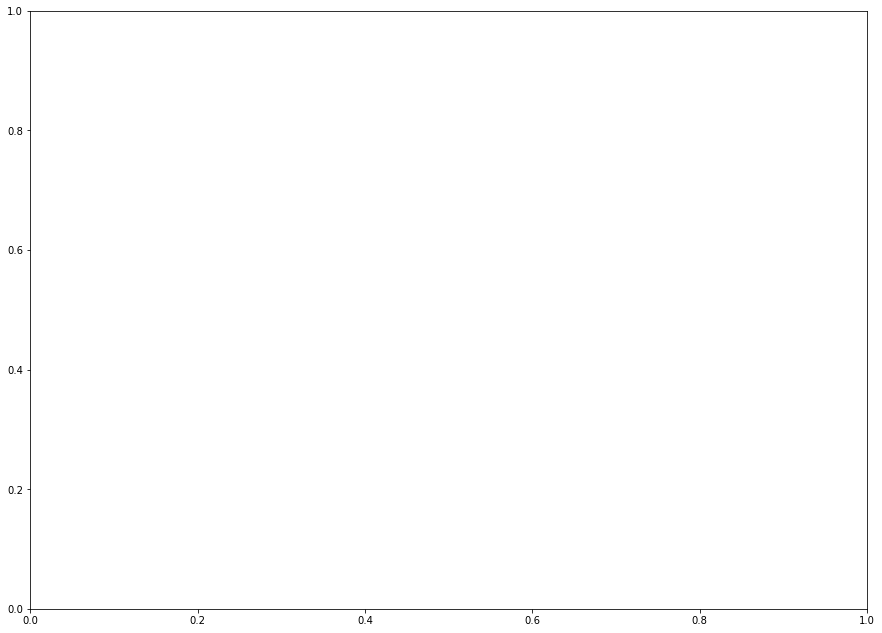

In [60]:
fig, ax = plt.subplots(figsize = (15, 11))
camera = Camera(fig)

In [61]:
import matplotlib.colors as mcolors
color_list = list(mcolors.CSS4_COLORS)

In [62]:
instantlocalization = InstantLocalization('하나스퀘어', 1)

In [63]:
#start_idx
start_idx = 0
how_many = 100

init_compare_list = []
init_x_list = []
init_y_list = []
before_x = 0
before_y = 0
gyro = 0
is_first = True
is_second = True
step_cnt = 0
for step in range(start_idx, start_idx + how_many):
    step_cnt += 1
    ans_x, ans_y, coords, compare_list_rssi = model.test_one(step)
    x_lis = coords[0]
    y_lis = coords[1]
    if is_first:
        first_c = [ans_x, ans_y]
        instantlocalization = InstantLocalization('하나스퀘어', 1)
        
        init_compare_list = compare_list_rssi
        init_x_list = [copy.deepcopy(x_lis) for i in range(36)]
        init_y_list = [copy.deepcopy(y_lis) for i in range(36)]
        
        before_x = ans_x
        before_y = ans_y
        
        instantlocalization.define_range([[min(init_x_list[i]), max(init_x_list[i]), min(init_y_list[i]), max(init_y_list[i])] \
                                         for i in range(36)])
        instantlocalization.getLocation(0.6, 0)
        
        is_first = False
    else:
        if is_second:
            second_c = [ans_x, ans_y]
            before_c = [ans_x, ans_y]
            is_second = False
        else:
            gyro = cal_gyro(first_c, second_c, before_c, [ans_x, ans_y])
            before_c = [ans_x, ans_y]
            
        chk_x_list = copy.deepcopy(init_x_list)
        chk_y_list = copy.deepcopy(init_y_list)
        
        init_x_list = []
        init_y_list = []
        for j in range(len(chk_x_list)):
            x, y = add_by_gyro(chk_x_list[j], chk_y_list[j], j * 10, gyro, 0.6)
            init_x_list.append(x)
            init_y_list.append(y)
        
        chk_x_list = copy.deepcopy(init_x_list)
        chk_y_list = copy.deepcopy(init_y_list)
        
        if not np.array_equal(init_compare_list, compare_list_rssi):
            init_compare_list = compare_list_rssi
            
            orig_x_list = copy.deepcopy(init_x_list)
            orig_y_list = copy.deepcopy(init_y_list)
            
            for i in range(len(init_x_list)):
                init_x_list[i], init_y_list[i] = intersect(chk_x_list[i], chk_y_list[i], x_lis, y_lis)
                        
        ans_range = []
        for i in range(36):
            if len(init_x_list[i]) * len(init_y_list[i]) != 0.0:
                ans_range.append([min(init_x_list[i]), max(init_x_list[i]), min(init_y_list[i]), max(init_y_list[i])])
            else:
                ans_range.append([0, 0, 0, 0])
        instantlocalization.define_range(ans_range)
        instantlocalization.getLocation(0.6, gyro)
        
    ax.imshow(model.mag_df, cmap='jet', interpolation='none')
    ax.text(0, 0, f"step {step_cnt}", fontsize=25)
    tot_x_list = []
    tot_y_list = []
    for mother in instantlocalization.instant_particle_mother_list:
        xlist = []
        ylist = []
        for children in mother.particle_children_list:
            xlist.append(children.x)
            ylist.append(children.y)
            tot_x_list.append(children.x)
            tot_y_list.append(children.y)
        ax.scatter(ylist, xlist, c = color_list[int(mother.my_angle / 10) + 10])
        
    ax.scatter(ans_y, ans_x, marker = 'X', s = 200, c = 'black')
    camera.snap()
#     if instantlocalization.instant_result['status_code'] == 101 or instantlocalization.instant_result['status_code'] == 200:
#         break

In [64]:
from IPython.display import HTML

animation = camera.animate(interval=500, repeat=True)
HTML(animation.to_html5_video())

In [17]:
animation.save('./compare_movies/하나스퀘어_4.mp4')

MovieWriter stderr:
./compare_movies/하나스퀘어_4.mp4: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1080x792', '-pix_fmt', 'rgba', '-r', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', './compare_movies/하나스퀘어_4.mp4']' returned non-zero exit status 1.

In [ ]:
import os



print(os.getcwd())